In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [31]:
def load_data(col=None, path='C:/Users/Christian/Documents/Cand_merc/Data-Science-Project/data_science_project/Praktik/data_final.xlsx', verbose=False):
    df = pd.read_excel(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

In [32]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [33]:
def split_data(series, train_fraq, test_len=977):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data

In [34]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [35]:
def build_dataset(train_fraq=0.8, 
                  n_steps=30, 
                  n_horizon=10, 
                  batch_size=32, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    
    """If multi variate then first column is always the column from which the target is contstructed.
    """

    tf.random.set_seed(23)
    if multi_var:    
        df = load_data(['clouds', 'ghi', 'pres', 'slp', 'solar_rad', 'temp', 'uv', 'datetime',
        'energy_total', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
        'hour_sin', 'hour_cos', 'sine_elevation', 'cosine_elevation',
        'sine_azimuth', 'cosine_azimuth'], verbose=True)
    else:
        df = load_data(['energy_total', 'datetime'], verbose=True)

    df = df[['energy_total'] + [col for col in df.columns if col != 'energy_total']]

    
    # Initially include all rows
    df["Include"] = True

    # Function to tag rows based on conditions
    def tag_abnormal_values(df, condition, include_col='Include'):
        """
        Updates the Include column to False for rows that satisfy the given condition.

        :param df: The DataFrame to modify.
        :param condition: A condition (boolean array or series) for abnormal values.
        :param include_col: The column name to update for inclusion.
        :return: Modified DataFrame with updated Include column.
        """
        df.loc[condition, include_col] = False
        return df

    # Define conditions for abnormality
    conditions = [
        (df['energy_total'] < 1) | (df['energy_total'] > 2800)
    ]

    # Exclude abnormal features
    for condition in conditions:
        df = tag_abnormal_values(df, condition)
    # Cut out all abnormal values
    df = df[df.Include].drop(["Include"], axis=1)

    #extract the hour from the datetime column
    df['hour'] = pd.DatetimeIndex(df['datetime']).hour

    #only keep rows where hour is between 8 and 18
    df = df[(df['hour'] >= 8) & (df['hour'] <= 18)]
    #delete three first rows
    df = df.iloc[3:]

    #drop hour column
    df = df.drop(['hour'], axis=1)

    #start the data from date 2022-03-30 08:00:00
    df = df[df['datetime'] >= '2022-03-30 08:00:00']

    #delete energy_total in df
    df = df.drop(columns=['datetime'], axis=1)

    #make the energy_total the first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]

    data = clean_data(df)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=977)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = build_dataset(multi_var=True)

   clouds  ghi  pres   slp  solar_rad  temp   uv            datetime  \
0      43  457  1026  1029        434  12.1  3.0 2022-03-25 09:00:00   
1       0  540  1026  1029        540  13.7  2.2 2022-03-25 10:00:00   
2       2  583  1026  1029        583  14.7  2.4 2022-03-25 11:00:00   
3      10  581  1026  1029        581  15.3  4.1 2022-03-25 12:00:00   
4      28  534  1025  1028        528  15.9  2.2 2022-03-25 13:00:00   

   energy_total  month_sin     month_cos   day_sin   day_cos      hour_sin  \
0        326.68        1.0  6.123234e-17  0.992222  0.124479 -5.877853e-01   
1        498.28        1.0  6.123234e-17  0.992222  0.124479 -2.449294e-16   
2        670.40        1.0  6.123234e-17  0.992222  0.124479  5.877853e-01   
3        693.04        1.0  6.123234e-17  0.992222  0.124479  9.510565e-01   
4        587.72        1.0  6.123234e-17  0.992222  0.124479  9.510565e-01   

   hour_cos  sine_elevation  cosine_elevation  sine_azimuth  cosine_azimuth  
0  0.809017        0

In [36]:
def get_params(multivar=False):
    learning_rate = 3e-4
    n_steps=30
    n_horizon=10
    if multivar:
        n_features=18
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, learning_rate

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, learning_rate = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, learning_rate=learning_rate)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [37]:
def dnn_model(n_steps, n_horizon, n_features, learning_rate=3e-4):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon * 1),  # Output matches total elements in target
        tf.keras.layers.Reshape((n_horizon, 1))  # Reshape to (n_horizon, 1)
    ], name='dnn')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=['mae']
    )
    return model



dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 540)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        69,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,050 (340.04 KB)

 Trainable params: 87,050 (340.04 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
for x_batch, y_batch in train_ds.take(1):
    print(f"Input batch shape (x_batch): {x_batch.shape}")
    print(f"Target batch shape (y_batch): {y_batch.shape}")


Input batch shape (x_batch): (32, 30, 18)
Target batch shape (y_batch): (32, 10, 1)


In [12]:
def cnn_model(n_steps, n_horizon, n_features, learning_rate=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 64)         │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def lstm_model(n_steps, n_horizon, n_features, learning_rate=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 72)         │        26,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │        23,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,002 (222.66 KB)

 Trainable params: 57,002 (222.66 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
def lstm_cnn_model(n_steps, n_horizon, n_features, learning_rate=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "lstm_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 64)         │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 72)          │        39,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │        23,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,578 (349.91 KB)

 Trainable params: 89,578 (349.91 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model_configs=dict()
#run_model("dnn", dnn_model, model_configs, epochs=10)
#run_model("cnn", cnn_model, model_configs, epochs=10)
#run_model("lstm", lstm_model, model_configs, epochs=100)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)

   clouds  ghi  pres   slp  solar_rad  temp   uv            datetime  \
0      43  457  1026  1029        434  12.1  3.0 2022-03-25 09:00:00   
1       0  540  1026  1029        540  13.7  2.2 2022-03-25 10:00:00   
2       2  583  1026  1029        583  14.7  2.4 2022-03-25 11:00:00   
3      10  581  1026  1029        581  15.3  4.1 2022-03-25 12:00:00   
4      28  534  1025  1028        528  15.9  2.2 2022-03-25 13:00:00   

   energy_total  month_sin     month_cos   day_sin   day_cos      hour_sin  \
0        326.68        1.0  6.123234e-17  0.992222  0.124479 -5.877853e-01   
1        498.28        1.0  6.123234e-17  0.992222  0.124479 -2.449294e-16   
2        670.40        1.0  6.123234e-17  0.992222  0.124479  5.877853e-01   
3        693.04        1.0  6.123234e-17  0.992222  0.124479  9.510565e-01   
4        587.72        1.0  6.123234e-17  0.992222  0.124479  9.510565e-01   

   hour_cos  sine_elevation  cosine_elevation  sine_azimuth  cosine_azimuth  
0  0.809017        0

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     20/Unknown 4s 6ms/step - loss: 0.0637 - mae: 0.2604

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0619 - mae: 0.2574 - val_loss: 0.0458 - val_mae: 0.2512
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0389 - mae: 0.2196 - val_loss: 0.0456 - val_mae: 0.2506
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0360 - mae: 0.2125 - val_loss: 0.0450 - val_mae: 0.2509
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0353 - mae: 0.2105 - val_loss: 0.0451 - val_mae: 0.2492
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0356 - mae: 0.2119 - val_loss: 0.0438 - val_mae: 0.2507
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0352 - mae: 0.2123 - val_loss: 0.0405 - val_mae: 0.2379
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0314 - mae: 0.1997 - val_loss: 0.0197 - val_mae: 0.1583
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0190 - mae: 0.1508 - val_loss: 0.0099 - val_mae: 0.1030
Epoch 9/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - mae: 0.

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 18), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


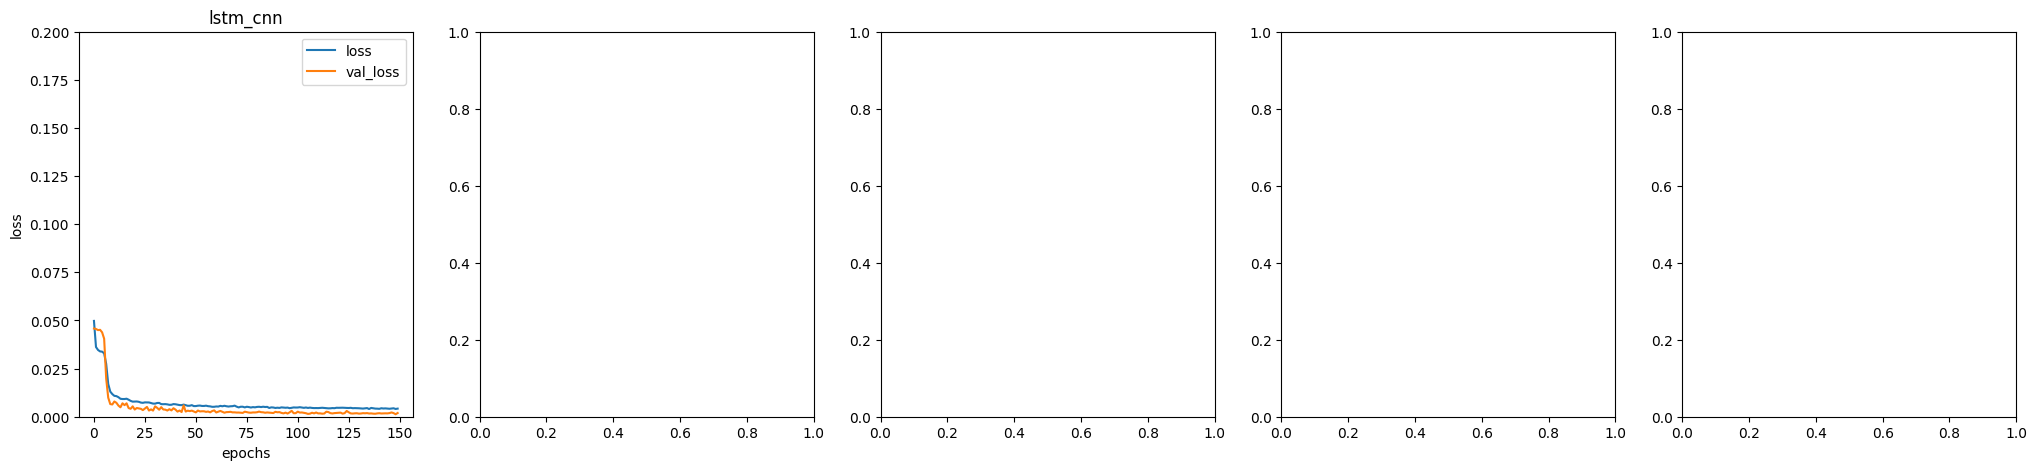

In [47]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


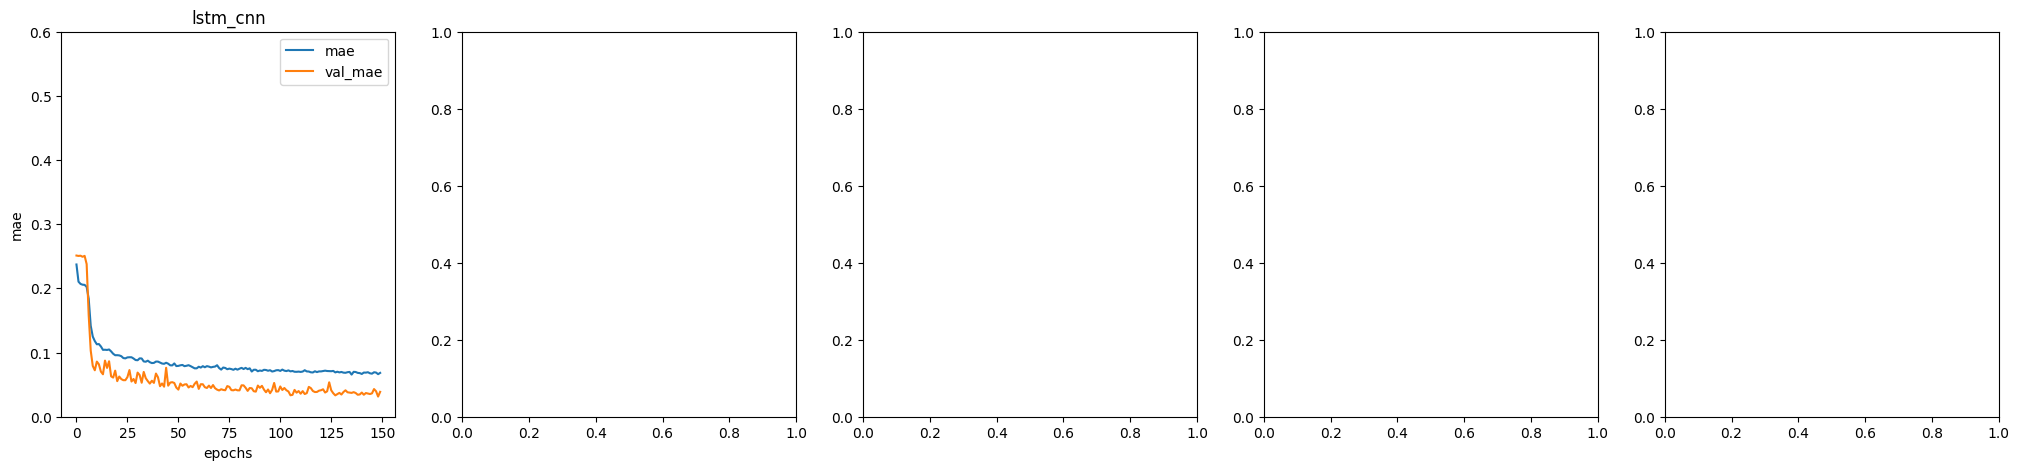

In [48]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

In [49]:
df = load_data(col=["energy_total"], verbose=True)
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['energy_total'].mean()
print(performance_df)  

   energy_total
0        326.68
1        498.28
2        670.40
3        693.04
4        587.72
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - mae: 0.0750
               mae   error_mw
lstm_cnn  0.077352  28.407149


c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
First Two Weeks of Predictions


c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


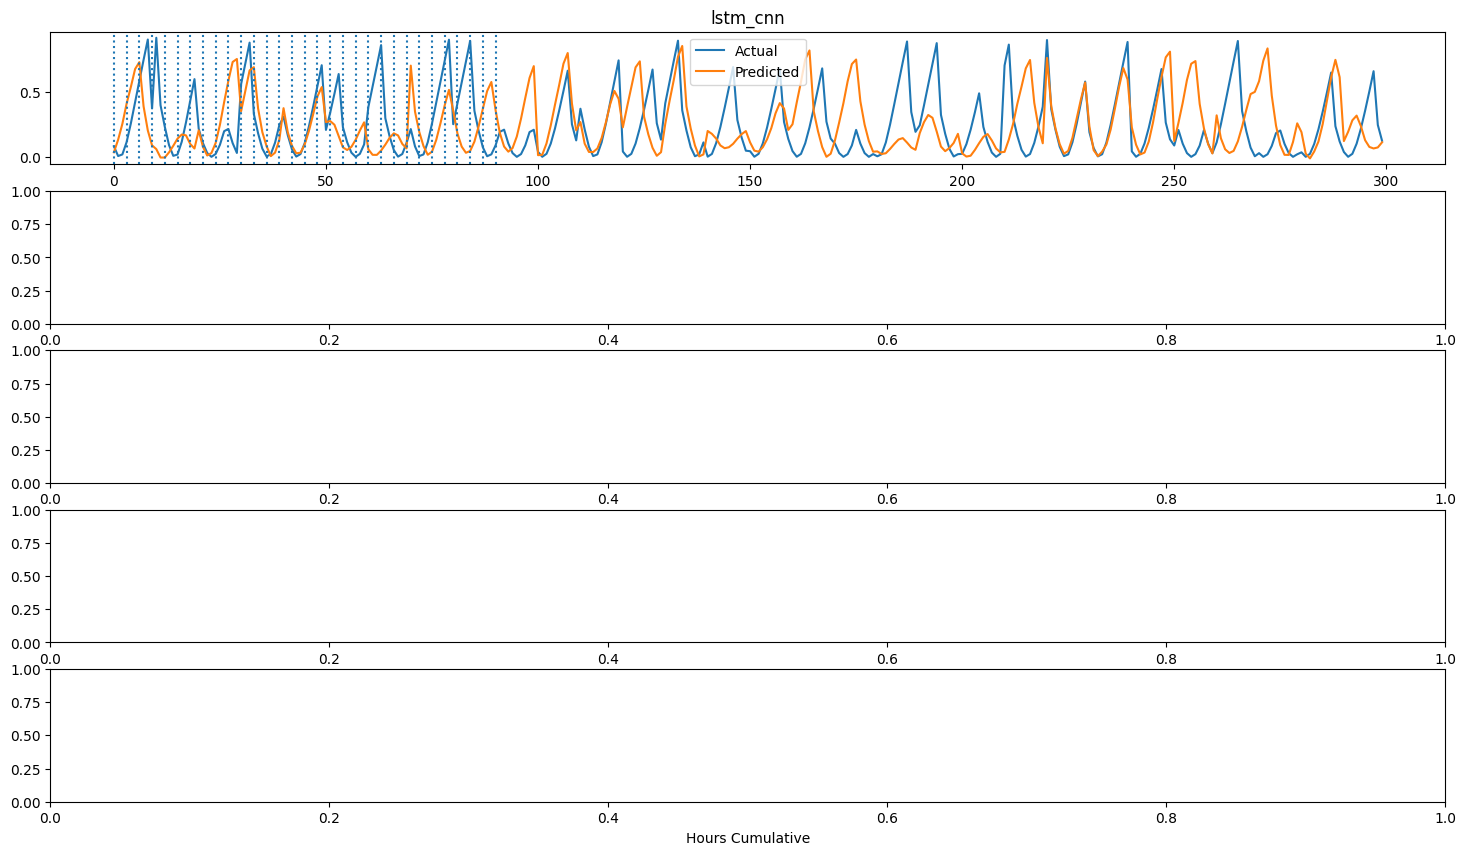

In [50]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 30

vline = np.linspace(0, days*3, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')